# Solving the SWE using NN + FNO

In [206]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim


## Load data

In [207]:
# Load a single .mat file
filename = 'dataFNO/data_sigma_no1.mat'
mat_data = scipy.io.loadmat(filename)

# Print the keys of the loaded data
print(mat_data.keys())

# Extract the necessary data (x and h_all) from the loaded data
x_mesh = mat_data['x'].flatten()
h_all = mat_data['h_all'][1:,:]
t_mesh = mat_data['time_all'].flatten()

h_all.shape
sigma = mat_data['sigma'][0,0]

print('sigma:', sigma)


dict_keys(['__header__', '__version__', '__globals__', 'h0', 'h_all', 'sigma', 'time_all', 'u_all', 'x'])
sigma: 0.1


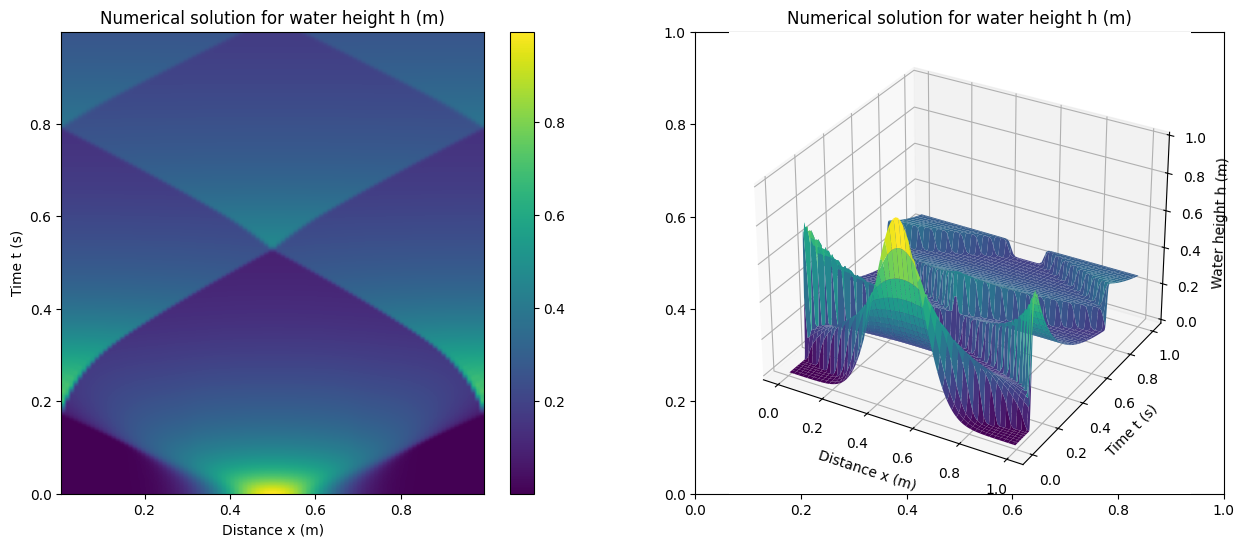

In [250]:
save = 0

# Plot the data in x,t space
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
img = ax[0].imshow(h_all, extent=[x_mesh[0], x_mesh[-1], t_mesh[-1], t_mesh[0]], aspect='auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Numerical solution for water height h (m)')
ax[0].set_xlabel('Distance x (m)')
ax[0].set_ylabel('Time t (s)')
ax[0].invert_yaxis()

# Plot in 3D
X, T = np.meshgrid(x_mesh, t_mesh)
ax[1] = fig.add_subplot(122, projection='3d')
ax[1].plot_surface(X, T, h_all, cmap='viridis')
ax[1].set_title('Numerical solution for water height h (m)')
ax[1].set_xlabel('Distance x (m)')
ax[1].set_ylabel('Time t (s)')
ax[1].set_zlabel('Water height h (m)')

if save:
    plt.savefig('plots/NN_initial.pdf', format='pdf')

plt.show()


### Function: prepare_data

In [209]:
def prepare_data(h_all, p_train, p_val):

    timesteps, _ = h_all.shape

    # Input a
    a = h_all[:-1]

    # Target u
    u = h_all[1:]

    # Split data into training, validation and test sets
    n_train = int(p_train * timesteps)
    n_val = int(p_val * timesteps)
    n_test = timesteps - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    # Define input and target training sets, validation sets and test sets
    train_x = torch.tensor(a[:n_train], dtype=torch.float32)
    train_y = torch.tensor(u[:n_train], dtype=torch.float32)

    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)

    test_x = torch.tensor(a[-n_test:], dtype=torch.float32)
    test_y = torch.tensor(u[-n_test:], dtype=torch.float32)

    x = torch.tensor(a, dtype=torch.float32)
    y = torch.tensor(u, dtype=torch.float32)

    #print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y


In [210]:
# Define percentage of data to use for training, validation, and testing
p_train = 0.6
p_val = 0.2

n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, p_train, p_val)

n_train = 182, n_val = 60, n_test = 62


In [233]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Solve the SWE using NN

### (i) FNN

In [212]:
in_features = 100
hidden1 = 128
hidden2 = 128
hidden3 = 64
out_features = 100

model = nn.Sequential(
    nn.Linear(in_features, hidden1),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden2, hidden3),
    nn.Linear(hidden3, out_features),
    nn.Sigmoid()
)

print(model)

Sequential(
  (0): Linear(in_features=100, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): Linear(in_features=64, out_features=100, bias=True)
  (8): Sigmoid()
)


In [213]:
# Define percentage of data to use for training, validation, and testing
p_train = 0.6
p_val = 0.2

n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, p_train, p_val)

dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

n_train = 182, n_val = 60, n_test = 62


In [ ]:
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_train = []
loss_val = []

# Training loop
n_epochs = 100

for epoch in range(n_epochs):
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_loss = loss_fn(model(val_x), val_y)

    # Average epoch loss
    loss /= len(dataset)
    val_loss /= len(dataset)

    # Append losses
    loss_train.append(loss.item())
    loss_val.append(val_loss.item())

    # Print loss every 10 epochs
    if epoch % 10 == 9:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.7f}")


Epoch 10/100, Loss: 0.0000465
Epoch 20/100, Loss: 0.0000318
Epoch 30/100, Loss: 0.0000236
Epoch 40/100, Loss: 0.0000166
Epoch 50/100, Loss: 0.0000177
Epoch 60/100, Loss: 0.0000146
Epoch 70/100, Loss: 0.0000168
Epoch 80/100, Loss: 0.0000111
Epoch 90/100, Loss: 0.0000107
Epoch 100/100, Loss: 0.0000098


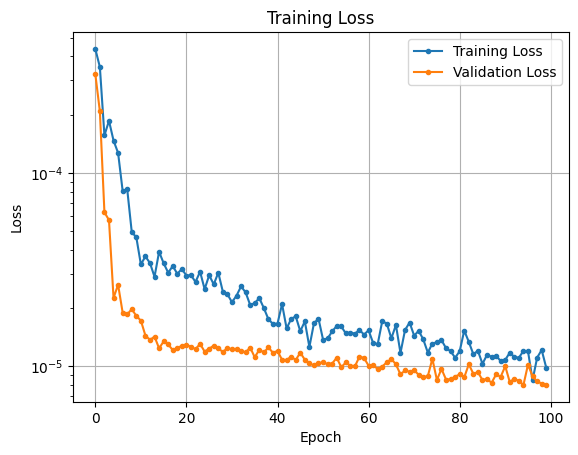

In [215]:
# Plot loss
plt.semilogy(loss_train, '.-', label='Training loss')
plt.semilogy(loss_val, '.-', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()


C:\Users\Matteo\AppData\Local\Temp\ipykernel_13112\301331998.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(y - predictions.detach().numpy()))


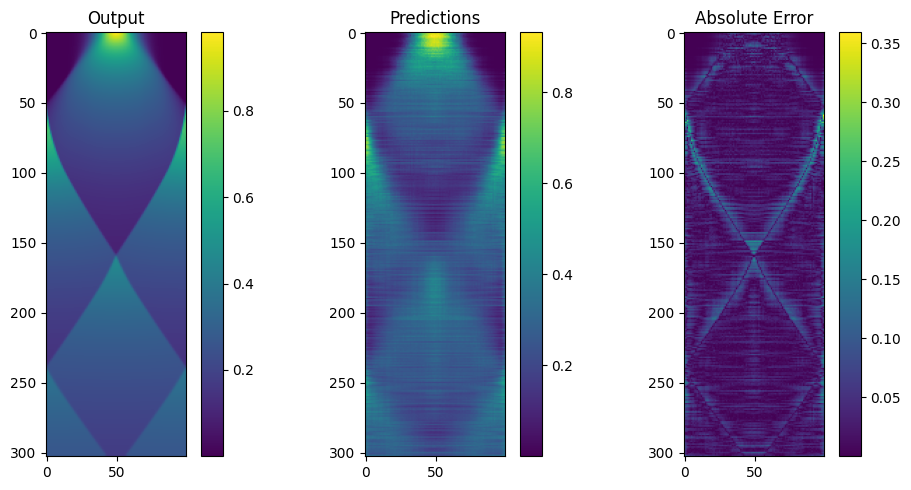

In [216]:
# Compute predictions
predictions = model(x)

# Plot the input, output, and predictions
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(y)
plt.colorbar()
plt.title('Output')

plt.subplot(1, 3, 2)
plt.imshow(predictions.detach().numpy())
plt.colorbar()
plt.title('Predictions')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(y - predictions.detach().numpy()))
plt.colorbar()
plt.title('Absolute Error')

plt.tight_layout()

plt.show()


### (ii) RNN Flowmap

In [235]:
# Define model
class RNNFlowmap(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0.2):
        super(RNNFlowmap, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last hidden state for prediction
        return out
    
input_size = 100
hidden_size = 128
output_size = 100

# Instantiate the model
model = RNNFlowmap(input_size, hidden_size, output_size)
print(model)


RNNFlowmap(
  (rnn): RNN(100, 128, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=100, bias=True)
  )
)


In [238]:
# Define percentage of data to use for training, validation, and testing
p_train = 0.8
p_val = 0

n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, p_train, p_val)

dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

n_train = 243, n_val = 0, n_test = 61


In [239]:
# Prepare data in sequences
def prepare_data_sequences(x, y, seq_length):
    timesteps, spatial_steps = x.shape

    # Number of sequences
    n_sequences = timesteps - seq_length

    # Prepare input and target sequences
    x_seq = torch.zeros((n_sequences, seq_length, spatial_steps))
    y_seq = torch.zeros((n_sequences, spatial_steps))

    for i in range(n_sequences):
        x_seq[i] = x[i:i + seq_length]
        y_seq[i] = y[i + seq_length]
    
    return x_seq, y_seq

In [240]:
seq_length = 10

X_input, X_output = prepare_data_sequences(train_x, train_y, seq_length)
print(X_input.shape, X_output.shape)

batch_size = 32

# Create a dataloader
dataset = torch.utils.data.TensorDataset(X_input, X_output)
train_loader = DataLoader(dataset, batch_size, shuffle=True)


torch.Size([233, 10, 100]) torch.Size([233, 100])


In [241]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_train = []
loss_val = []

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0.0  # Track loss for the epoch
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)  # Shape: (batch_size, output_size)
        loss = torch.mean((predictions - batch_y)**2)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for total loss

    # Average epoch loss
    epoch_loss /= len(dataset)
    val_loss /= len(dataset)

    # Append losses
    loss_train.append(epoch_loss)
    loss_val.append(val_loss)

    # Print epoch loss
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.6f}")

Epoch 10/100, Loss: 0.003333
Epoch 20/100, Loss: 0.001930
Epoch 30/100, Loss: 0.001312
Epoch 40/100, Loss: 0.001146
Epoch 50/100, Loss: 0.000906
Epoch 60/100, Loss: 0.000735
Epoch 70/100, Loss: 0.000636
Epoch 80/100, Loss: 0.000549
Epoch 90/100, Loss: 0.000565
Epoch 100/100, Loss: 0.000517


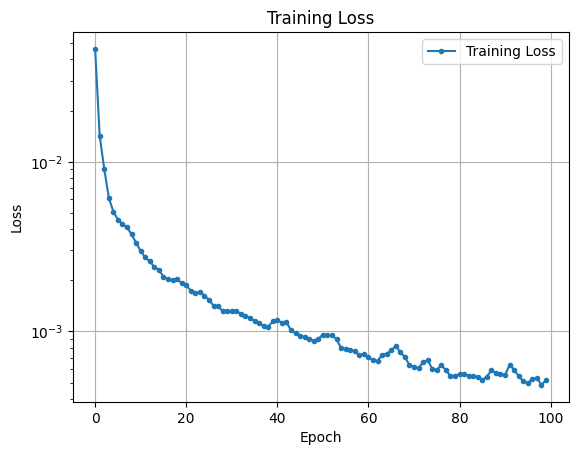

In [ ]:
# Plot loss
plt.figure()
plt.semilogy(loss_train, '.-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()

plt.show()

In [243]:
X_all, Y_all = prepare_data_sequences(x, y, seq_length=10)

# Predictions
model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predictions = model(X_all)  # Full dataset
    test_loss = loss_fn(predictions, Y_all)
    print(f"Test Loss: {test_loss.item():.6f}")

Test Loss: 0.000537


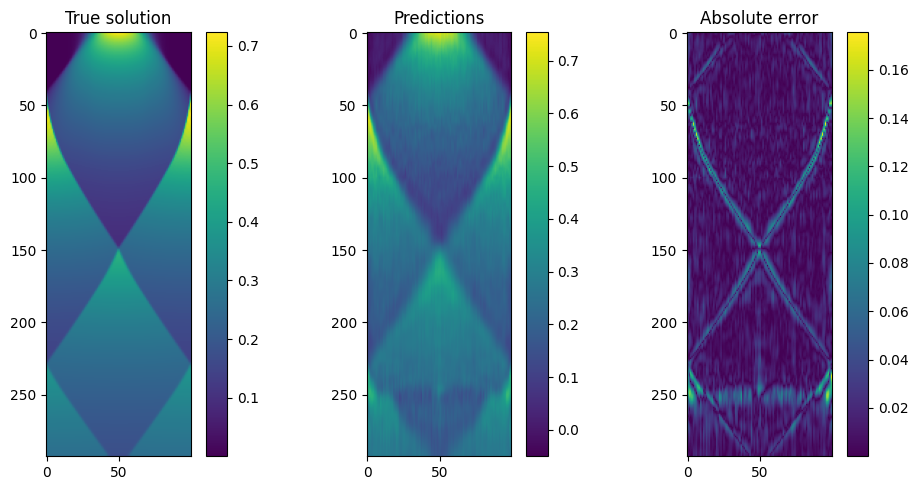

In [244]:
# Plot the output, predictions and absolute error
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(Y_all.numpy())
plt.colorbar()
plt.title('True solution')

plt.subplot(1, 3, 2)
plt.imshow(predictions.numpy())
plt.colorbar()
plt.title('Predictions')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(Y_all.numpy() - predictions.numpy()))
plt.colorbar()
plt.title('Absolute error')

plt.tight_layout()

plt.show()

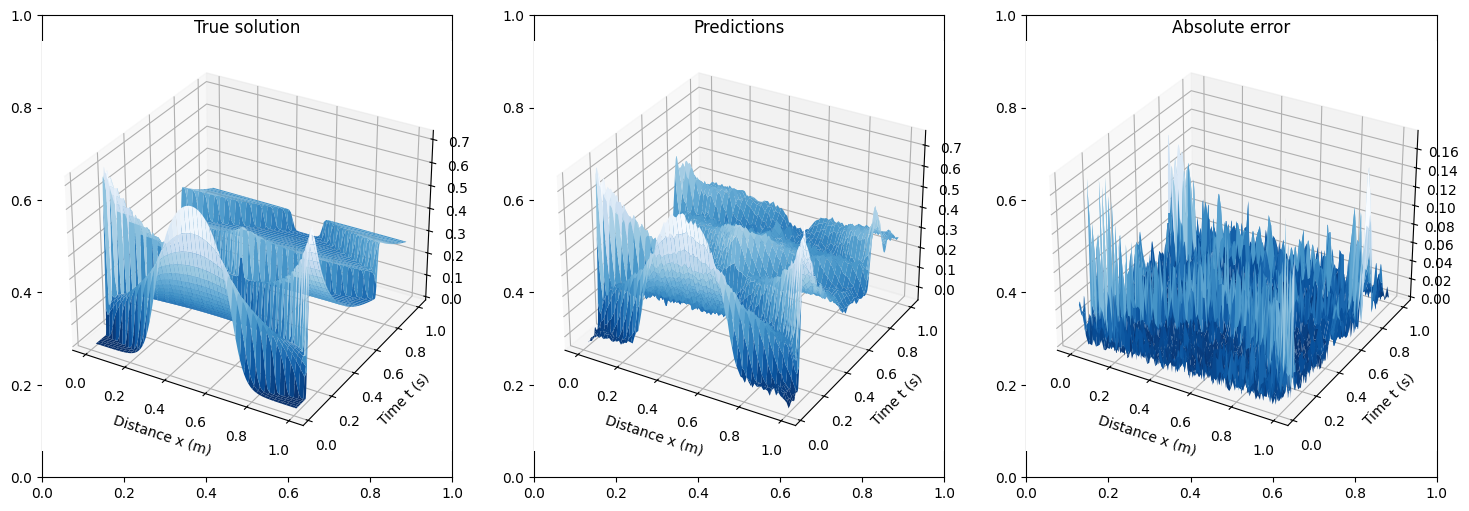

In [245]:
# Prepare grid
X, T = np.meshgrid(x_mesh, t_mesh[seq_length+1:])

# Plot the output, predictions and absolute error
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

cmap = 'Blues_r'

# Plot in 3d
ax[0] = fig.add_subplot(131, projection='3d')
ax[0].plot_surface(X, T, Y_all.numpy(), cmap=cmap)
ax[0].set_title('True solution')
ax[0].set_xlabel('Distance x (m)')
ax[0].set_ylabel('Time t (s)')

ax[1] = fig.add_subplot(132, projection='3d')
ax[1].plot_surface(X, T, predictions.numpy(), cmap=cmap)
ax[1].set_title('Predictions')
ax[1].set_xlabel('Distance x (m)')
ax[1].set_ylabel('Time t (s)')

ax[2] = fig.add_subplot(133, projection='3d')
ax[2].plot_surface(X, T, np.abs(Y_all.numpy() - predictions.numpy()), cmap=cmap)
ax[2].set_title('Absolute error')
ax[2].set_xlabel('Distance x (m)')
ax[2].set_ylabel('Time t (s)')

plt.show()

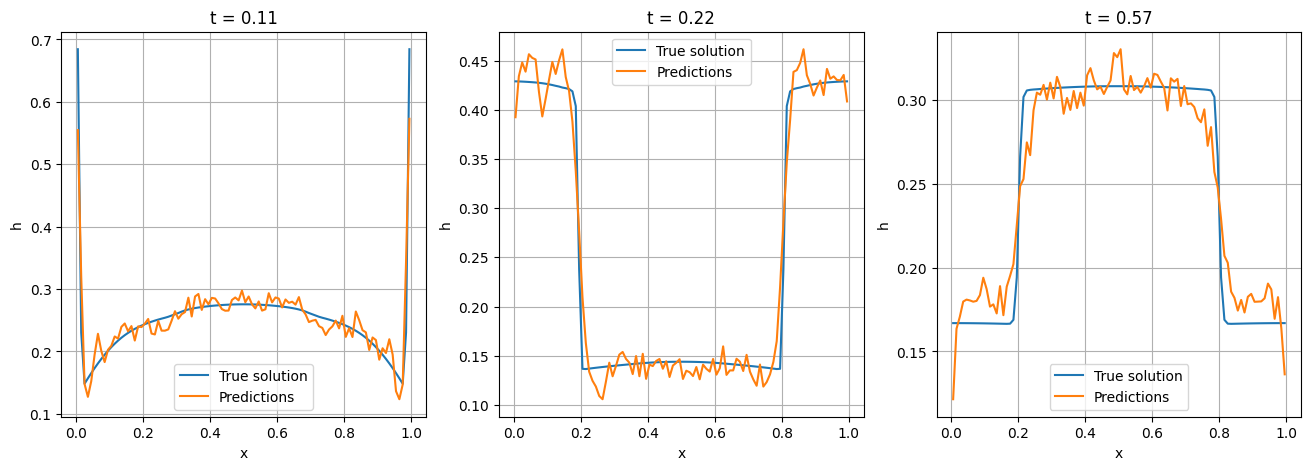

In [247]:
# Plot for some given time steps
indices = [50, 100, 200]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

for i, idx in enumerate(indices):
    ax = axes[i]
    ax.plot(x_mesh, Y_all[idx].numpy(), label='True solution')
    ax.plot(x_mesh, predictions[idx].numpy(), label='Predictions')
    ax.set_title(f"t = {t_mesh[idx]:.2f}")
    ax.set_xlabel('x')
    ax.set_ylabel('h')
    ax.grid()
    ax.legend()

### (iii) LSTM (Long short-term memory)

In [228]:
# LSTM class neural network
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0.2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 100
hidden_size = 128
output_size = 100

# Define model
model = LSTM(input_size, hidden_size, output_size)
print(model)

LSTM(
  (lstm): LSTM(100, 128, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=100, bias=True)
  )
)


In [229]:
# Define sequence length
sequence_length = 5
num_sequences = 243 - sequence_length
X = h_train.copy()
batch_size = 32

# Create input-output pairs
X_input = []
X_output = []

for i in range(num_sequences):
    X_input.append(X[i:i+sequence_length])    # Sequence of length 5
    X_output.append(X[i+sequence_length])    # Next time step

X_input = np.array(X_input)  # Shape: (num_sequences, sequence_length, 100)
X_output = np.array(X_output)  # Shape: (num_sequences, 100)

X_input_tensor = torch.tensor(X_input, dtype=torch.float32)
X_output_tensor = torch.tensor(X_output, dtype=torch.float32)

# Create a DataLoader
batch_size = 32
dataset = torch.utils.data.TensorDataset(X_input_tensor, X_output_tensor)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [230]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0.0  # Track loss for the epoch
    
    for batch_X, batch_y in data_loader:
        # Forward pass
        predictions = model(batch_X)  # Shape: (batch_size, output_size)
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for total loss

    # Average epoch loss
    epoch_loss /= len(dataset)
    losses.append(epoch_loss)
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.6f}")

Epoch 10/10, Loss: 0.014253


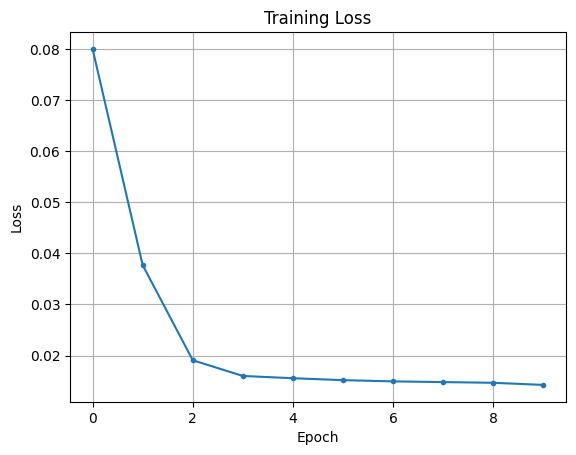

In [231]:
# Plot loss
plt.plot(losses, '.-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

Test Loss: 0.013345


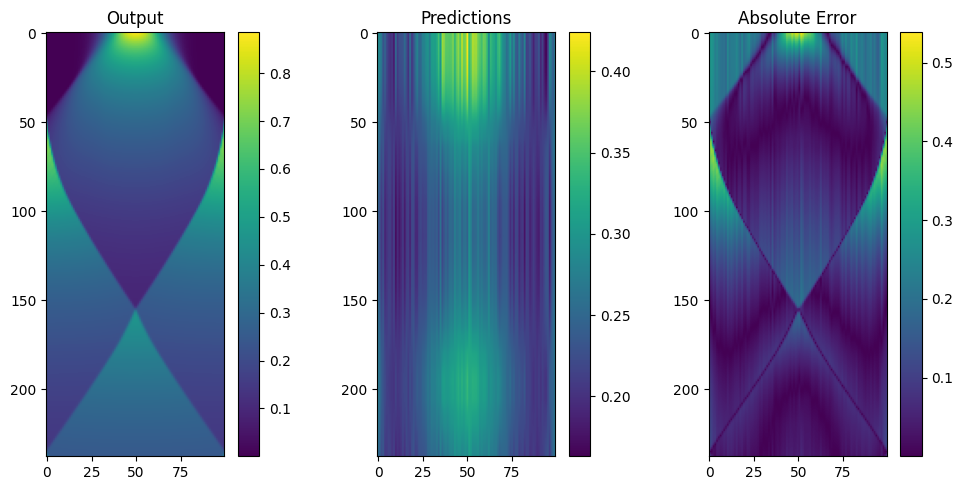

In [232]:
model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predictions = model(X_input_tensor)  # Full dataset
    test_loss = loss_fn(predictions, X_output_tensor)
    print(f"Test Loss: {test_loss.item():.6f}")

# Plot the input, output, and predictions
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(X_output)
plt.colorbar()
plt.title('Output')

plt.subplot(1, 3, 2)
plt.imshow(predictions.numpy())
plt.colorbar()
plt.title('Predictions')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(X_output - predictions.numpy()))
plt.colorbar()
plt.title('Absolute Error')

plt.tight_layout()
plt.show()
